### Data Import and Processing

In [2]:
# Import required packages
import pickle
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import sentence_transformers
from sentence_transformers import SentenceTransformer, InputExample, losses
import xgboost as xgb
from hyperopt import hp, tpe, Trials, fmin
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import data and check its dimensions
data = pd.read_csv('./content/raw_classification_data.csv')

print(data.shape)
data.head()

(2259, 2)


,title,label
0,"Director, Learning and Support",CLASS1
1,Customer Service Assistant,CLASS2
2,2023 Internship and Education Program Manageme...,CLASS13
3,Communications Technician,CLASS13
4,Emergency Preparedness Officer,CLASS3


In [3]:
# Check if all titles are unique
data['title'].nunique()

2259

In [4]:
# Count number of observations in each class
data['label'].value_counts()

CLASS13    489
CLASS4     373
CLASS5     300
CLASS6     263
CLASS8     225
CLASS7     168
CLASS10    119
CLASS3      94
CLASS11     81
CLASS1      76
CLASS2      40
CLASS9      28
CLASS12      3
Name: label, dtype: int64

<Axes: ylabel='label'>

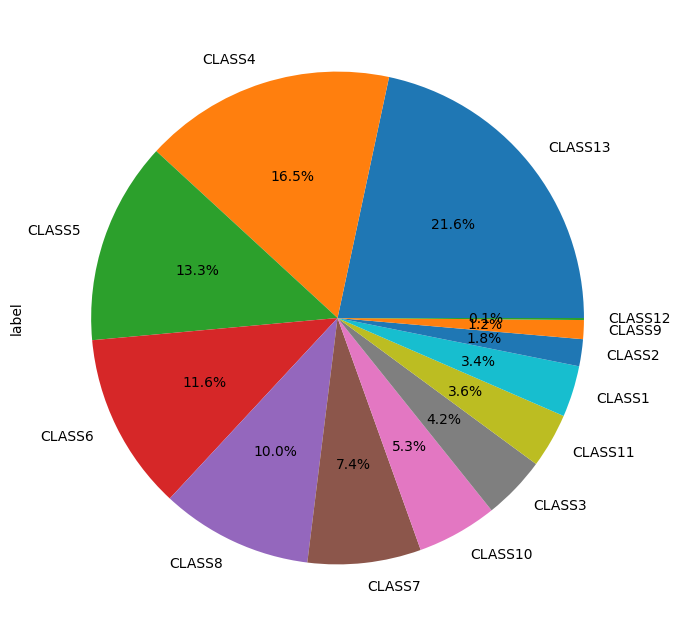

In [5]:
# Pie Chart showing percent of observations in each class
data['label'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(8,8))

In [6]:
# Remove the prefix 'CLASS' from label and convert to integer (-1 to start class label with 0)
data['num_label'] = pd.to_numeric(data['label'].str.replace('CLASS', ''), errors='coerce', downcast='integer') - 1
data.head()

,title,label,num_label
0,"Director, Learning and Support",CLASS1,0
1,Customer Service Assistant,CLASS2,1
2,2023 Internship and Education Program Manageme...,CLASS13,12
3,Communications Technician,CLASS13,12
4,Emergency Preparedness Officer,CLASS3,2


In [7]:
# Ensure the frequency distribution of classes is same as before
data['num_label'].value_counts()

12    489
3     373
4     300
5     263
7     225
6     168
9     119
2      94
10     81
0      76
1      40
8      28
11      3
Name: num_label, dtype: int64

In [8]:
# Text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [9]:
# Apply text processing function to title
data['processed_text'] = data['title'].apply(preprocess_text)

In [10]:
# Check results of processing
data[['title' ,'processed_text']].head()

,title,processed_text
0,"Director, Learning and Support",director learning support
1,Customer Service Assistant,customer service assistant
2,2023 Internship and Education Program Manageme...,internship education program management intern
3,Communications Technician,communication technician
4,Emergency Preparedness Officer,emergency preparedness officer


In [11]:
# Check if title is still unique
data['processed_text'].nunique()

2241

In [12]:
# Check which processed titles have duplicates (We are not removing the duplicates)
data[data.duplicated(subset=['processed_text'], keep='first')].sort_values('num_label')

,title,label,num_label,processed_text
1022,"Director, Total Rewards",CLASS1,0,director total reward
1092,Global Support L2 Agent,CLASS2,1,global support l agent
1895,Spezialist Sanierungs-/Abwicklungsplanung (w/m...,CLASS3,2,spezialist sanierungsabwicklungsplanung wmx pu...
1879,Manager Central Knowledge Management & Selfcar...,CLASS6,5,manager central knowledge management selfcare ...
1900,Internationaler MobilitÃƒÂ¤tsmanager (w/m/x) P...,CLASS7,6,internationaler mobilitãƒâ¤tsmanager wmx publi...
198,"Quality Review Specialist - HEDIS - January 2,...",CLASS8,7,quality review specialist hedis january start ...
1442,Praktikant im Bereich Gesamtfahrzeug (w/m/x) P...,CLASS8,7,praktikant im bereich gesamtfahrzeug wmx publi...
566,Functional Safety Engineer,CLASS8,7,functional safety engineer
332,MBE Billing and Accounting Specialist,CLASS10,9,mbe billing accounting specialist
1108,Senior Support Engineer T2 Parallels Desktop,CLASS11,10,senior support engineer parallel desktop


In [13]:
# Save processed data
data.to_csv('./content/processed_classification_data.csv')

## Train classifier without Finetuning 'sentence-transformers/all-MiniLM-L6-v2'

In [14]:
# Import 'sentence-transformers/all-MiniLM-L6-v2' model from Hugging Face
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [15]:
# Create embeddings for 'job titles'
data['embeddings'] = data['processed_text'].apply(model.encode)

In [16]:
# Check data dimension and print few rows
print(data.shape)
data.head()

(2259, 5)


,title,label,num_label,processed_text,embeddings
0,"Director, Learning and Support",CLASS1,0,director learning support,"[-0.016121084, -0.13359962, 0.026733423, 0.022..."
1,Customer Service Assistant,CLASS2,1,customer service assistant,"[-0.16010167, -0.012119542, 0.0028915794, -0.0..."
2,2023 Internship and Education Program Manageme...,CLASS13,12,internship education program management intern,"[-0.01080601, 0.04149282, 0.030234074, 0.00930..."
3,Communications Technician,CLASS13,12,communication technician,"[-0.0757357, 0.010937532, 0.04794518, 0.003866..."
4,Emergency Preparedness Officer,CLASS3,2,emergency preparedness officer,"[-0.012550723, 0.035553087, 0.0030892317, 0.08..."


In [17]:
# Ensure all embeddings are of same length
min(data['embeddings'].apply(len)) == max(data['embeddings'].apply(len))

True

In [18]:
# Apply avg pooling to flatten the embeddings
data['flat_embeddings'] = data['embeddings'].apply(lambda emb_list: np.mean(emb_list, axis=0))

In [19]:
# Define data and labels (Since CLASS 11 has only 3 observations, we will assign them one each to train, test, val)
X = data.loc[(data['num_label'] != 11)]['flat_embeddings']
y = data.loc[(data['num_label'] != 11)]['num_label']

# Define the ratios for train, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Perform the initial train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio, stratify=y, random_state=42)

# Further split the temporary set into validation and test sets
relative_val_ratio = val_ratio / (val_ratio + test_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1 - relative_val_ratio, stratify=y_temp, random_state=42)

# Seperate out 3 observations of CLASS 11
class12_data = data.loc[(data['num_label'] == 11)][['flat_embeddings']]
class12_labels = data.loc[(data['num_label'] == 11)][['num_label']]

# Assign one each of 3 observations to train, test, val
X_train = X_train.append(class12_data.iloc[0], ignore_index=True)
y_train = y_train.append(class12_labels.iloc[0], ignore_index=True)

X_test = X_test.append(class12_data.iloc[1], ignore_index=True)
y_test = y_test.append(class12_labels.iloc[1], ignore_index=True)

X_val = X_val.append(class12_data.iloc[2], ignore_index=True)
y_val = y_val.append(class12_labels.iloc[2], ignore_index=True)

# Check the final sizes
print(len(X_train))
print(len(X_test))
print(len(X_val))

print(len(y_train))
print(len(y_test))
print(len(y_val))

1354
453
452
1354
453
452


In [20]:
# Train a XGBoost multi-class classifier

# Define the hyperparameter search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 20),
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y)),
}

# Define the objective function for hyperparameter optimization
def objective(params):
    # quniform can return float but XGBoost expects integer
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    clf = xgb.XGBClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Hyperopt minimizes the objective function

# Create a Trials object to keep track of the optimization process
trials = Trials()

# Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.default_rng(seed=42))

print("Best hyperparameters:", best)

# Train the final model with the best hyperparameters
best_params = {k: best[k] if k != 'n_estimators' else int(best[k]) for k in best}

# quniform can return float but XGBoost expects integer
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Final model accuracy:", accuracy)

100%|██████████| 50/50 [00:19<00:00,  2.60trial/s, best loss: -0.22075055187637968]
Best hyperparameters: {'gamma': 1.0606877339901337, 'learning_rate': 0.29571515528619036, 'max_depth': 8.0, 'n_estimators': 174.0}
Final model accuracy: 0.22075055187637968


In [21]:
# Create Predictions
y_pred_train = final_model.predict(np.vstack(X_train.tolist()))
y_pred_test = final_model.predict(np.vstack(X_test.tolist()))
y_pred_val = final_model.predict(np.vstack(X_val.tolist()))

In [22]:
# Calculate Classification Metrics
acc_train = accuracy_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train, labels=final_model.classes_)
report_train = classification_report(y_train, y_pred_train)

acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test, labels=final_model.classes_)
report_test = classification_report(y_test, y_pred_test)

acc_val = accuracy_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val, labels=final_model.classes_)
report_val = classification_report(y_val, y_pred_val)

In [23]:
# Print Accuracy and Classification Report
print("Classification without fine tuning transformer model \n")
print("--------------------")
print("--------TRAIN-------")
print("--------------------")
print("Accuracy: ", acc_train)
print("--------------------\n")
print("Model peformance table: \n", report_train)

print("--------------------")
print("--------TEST--------")
print("--------------------")
print("Accuracy: ", acc_test)
print("--------------------\n")
print("Model peformance table: \n", report_test)

print("--------------------")
print("--------VAL---------")
print("--------------------")
print("Accuracy: ", acc_val)
print("--------------------\n")
print("Model peformance table: \n", report_val)

Classification without fine tuning transformer model 

--------------------
--------TRAIN-------
--------------------
Accuracy:  0.24076809453471196
--------------------

Model peformance table: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        56
           3       0.32      0.14      0.20       224
           4       0.42      0.03      0.05       180
           5       0.00      0.00      0.00       158
           6       0.00      0.00      0.00       101
           7       0.41      0.07      0.11       135
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        71
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00         1
          12       0.23      0.96      0.37       293

    accuracy                           0.24  

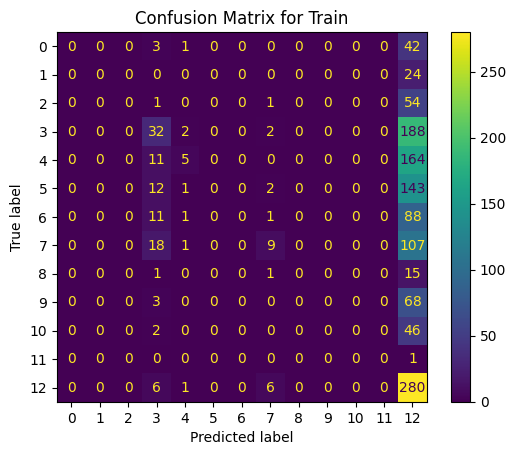

In [24]:
# Plot Confusion Matrix for Train
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Train")
plt.show()

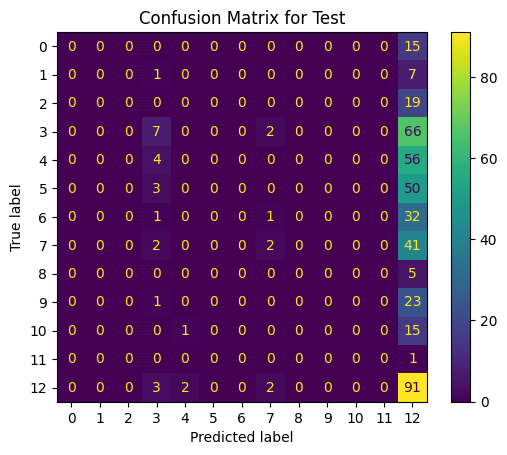

In [25]:
# Plot Confusion Matrix for Test
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Test")
plt.show()

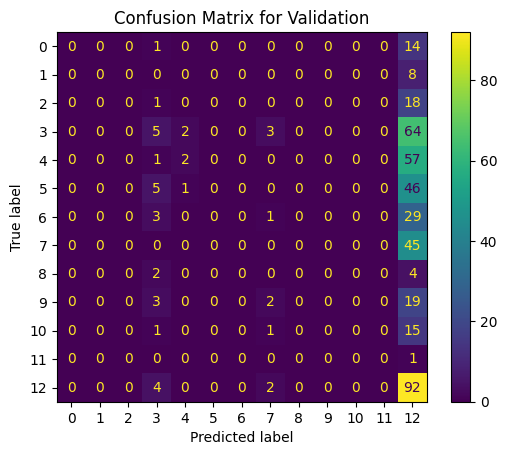

In [26]:
# Plot Confusion Matrix for Validation
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Validation")
plt.show()

In [27]:
# Save both embeddings and classification model

model.save("./content/Untuned_all-MiniLM-L6-v2")

# To Open:
# model = SentenceTransformer("./content/Untuned_all-MiniLM-L6-v2")

with open("./content/xgboost_clf_model_without_transformer_tuning.pkl", "wb") as f:
    pickle.dump(final_model, f)

# To Open:
# with open("./content/xgboost_clf_model_without_transformer_tuning.pkl", "rb") as f:
#   model = pickle.load(f)

## Train classifier with Finetuning 'sentence-transformers/all-MiniLM-L6-v2'

In [28]:
# Prepare the training data
# Since we will use CosineSimilarityLoss:
# - we need to bound labels in [0, 1] (label is an optional argument in fine tuning)
# - calculating similarity requires two arguments, so we will need to create pairs of texts

train_pairs = []

def create_train_pairs(df):
    """
    Creates pairs of texts for each row in the DataFrame,
    ensuring that one of the texts in the pair is the text in the row itself
    and the other is randomly selected within the label.
    """

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        # Get the current text
        current_text = row['processed_text']

        # Randomly sample a different text from the same label
        other_text = random.choice(df[df['num_label'] == row['num_label']]['processed_text'].tolist())

        # Create an InputExample object for each sentence pair
        train_pairs.append(InputExample(texts=[current_text, other_text], label=row['num_label'] / 12))


# Create pairs of texts for each label in the DataFrame
create_train_pairs(data)

In [31]:
# Load the pre-trained sentence transformer model
model = sentence_transformers.SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Prepare the dataloader
train_dataloader = DataLoader(train_pairs, shuffle=True, batch_size=16)

# Choose a loss function
loss_function = losses.CosineSimilarityLoss(model)

# Define the training parameters
train_params = {
    "train_objectives": [(train_dataloader, loss_function)],
    "epochs": 10,
    "warmup_steps": 100
}

# Fine-tune the model
model.fit(**train_params)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

Iteration:   0%|          | 0/142 [00:00<?, ?it/s]

In [32]:
# Save the fine-tuned model
model.save("./content/fine-tuned-all-MiniLM-L6-v2")

In [33]:
# Load saved model
saved_model = sentence_transformers.SentenceTransformer("./content/fine-tuned-all-MiniLM-L6-v2")

In [34]:
# Create embeddings for 'job titles'
data['new_embeddings'] = data['processed_text'].apply(saved_model.encode)

In [35]:
# Check data dimension and print few rows
print(data.shape)
data.head()

(2259, 7)


,title,label,num_label,processed_text,embeddings,flat_embeddings,new_embeddings
0,"Director, Learning and Support",CLASS1,0,director learning support,"[-0.016121084, -0.13359962, 0.026733423, 0.022...",0.002196,"[-0.031751566, -0.10605747, 0.019078903, -0.04..."
1,Customer Service Assistant,CLASS2,1,customer service assistant,"[-0.16010167, -0.012119542, 0.0028915794, -0.0...",0.000776,"[-0.050243124, -0.006659993, -0.028727483, -0...."
2,2023 Internship and Education Program Manageme...,CLASS13,12,internship education program management intern,"[-0.01080601, 0.04149282, 0.030234074, 0.00930...",-0.000165,"[-0.065847434, 0.049345385, -0.003509135, 0.02..."
3,Communications Technician,CLASS13,12,communication technician,"[-0.0757357, 0.010937532, 0.04794518, 0.003866...",0.001905,"[-0.106090665, 0.0455094, -0.031952914, 0.0030..."
4,Emergency Preparedness Officer,CLASS3,2,emergency preparedness officer,"[-0.012550723, 0.035553087, 0.0030892317, 0.08...",0.000950,"[-0.051156092, 0.038347002, -0.021691987, 0.05..."


In [36]:
# Ensure all embeddings are of same length
min(data['new_embeddings'].apply(len)) == max(data['new_embeddings'].apply(len))

True

In [37]:
# Apply avg pooling to flatten the embeddings
data['new_flat_embeddings'] = data['new_embeddings'].apply(lambda emb_list: np.mean(emb_list, axis=0))

In [38]:
# Define data and labels (Since CLASS 11 has only 3 observations, we will assign them one each to train, test, val)
X = data.loc[(data['num_label'] != 11)]['new_flat_embeddings']
y = data.loc[(data['num_label'] != 11)]['num_label']

# Define the ratios for train, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Perform the initial train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio, stratify=y, random_state=42)

# Further split the temporary set into validation and test sets
relative_val_ratio = val_ratio / (val_ratio + test_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1 - relative_val_ratio, stratify=y_temp, random_state=42)

# Seperate out 3 observations of CLASS 11
class12_data = data.loc[(data['num_label'] == 11)][['new_flat_embeddings']]
class12_labels = data.loc[(data['num_label'] == 11)][['num_label']]

# Assign one each of 3 observations to train, test, val
X_train = X_train.append(class12_data.iloc[0], ignore_index=True)
y_train = y_train.append(class12_labels.iloc[0], ignore_index=True)

X_test = X_test.append(class12_data.iloc[1], ignore_index=True)
y_test = y_test.append(class12_labels.iloc[1], ignore_index=True)

X_val = X_val.append(class12_data.iloc[2], ignore_index=True)
y_val = y_val.append(class12_labels.iloc[2], ignore_index=True)

# Check the final sizes
print(len(X_train))
print(len(X_test))
print(len(X_val))

print(len(y_train))
print(len(y_test))
print(len(y_val))

1354
453
452
1354
453
452


In [39]:
# Train a XGBoost multi-class classifier

# Define the hyperparameter search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 0, 20),
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y)),
}

# Define the objective function for hyperparameter optimization
def objective(params):
    # quniform can return float but XGBoost expects integer
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    clf = xgb.XGBClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Hyperopt minimizes the objective function

# Create a Trials object to keep track of the optimization process
trials = Trials()

# Perform Bayesian optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.default_rng(seed=42))

print("Best hyperparameters:", best)

# Train the final model with the best hyperparameters
best_params = {k: best[k] if k != 'n_estimators' else int(best[k]) for k in best}

# quniform can return float but XGBoost expects integer
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Final model accuracy:", accuracy)

100%|██████████| 50/50 [00:15<00:00,  3.32trial/s, best loss: -0.32229580573951433]
Best hyperparameters: {'gamma': 1.1987237816280105, 'learning_rate': 0.25966983975489605, 'max_depth': 7.0, 'n_estimators': 125.0}
Final model accuracy: 0.32229580573951433


In [40]:
# Create Predictions
y_pred_train = final_model.predict(np.vstack(X_train.tolist()))
y_pred_test = final_model.predict(np.vstack(X_test.tolist()))
y_pred_val = final_model.predict(np.vstack(X_val.tolist()))

In [41]:
# Calculate Classification Metrics
acc_train = accuracy_score(y_train, y_pred_train)
cm_train = confusion_matrix(y_train, y_pred_train, labels=final_model.classes_)
report_train = classification_report(y_train, y_pred_train)

acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test, labels=final_model.classes_)
report_test = classification_report(y_test, y_pred_test)

acc_val = accuracy_score(y_val, y_pred_val)
cm_val = confusion_matrix(y_val, y_pred_val, labels=final_model.classes_)
report_val = classification_report(y_val, y_pred_val)

In [42]:
# Print Accuracy and Classification Report
print("Classification without fine tuning transformer model \n")
print("--------------------")
print("--------TRAIN-------")
print("--------------------")
print("Accuracy: ", acc_train)
print("--------------------\n")
print("Model peformance table: \n", report_train)

print("--------------------")
print("--------TEST--------")
print("--------------------")
print("Accuracy: ", acc_test)
print("--------------------\n")
print("Model peformance table: \n", report_test)

print("--------------------")
print("--------VAL---------")
print("--------------------")
print("Accuracy: ", acc_val)
print("--------------------\n")
print("Model peformance table: \n", report_val)

Classification without fine tuning transformer model 

--------------------
--------TRAIN-------
--------------------
Accuracy:  0.3552437223042836
--------------------

Model peformance table: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        56
           3       0.33      0.31      0.32       224
           4       0.29      0.53      0.38       180
           5       0.28      0.20      0.23       158
           6       0.60      0.06      0.11       101
           7       0.00      0.00      0.00       135
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        71
          10       0.00      0.00      0.00        48
          11       0.00      0.00      0.00         1
          12       0.40      0.95      0.57       293

    accuracy                           0.36   

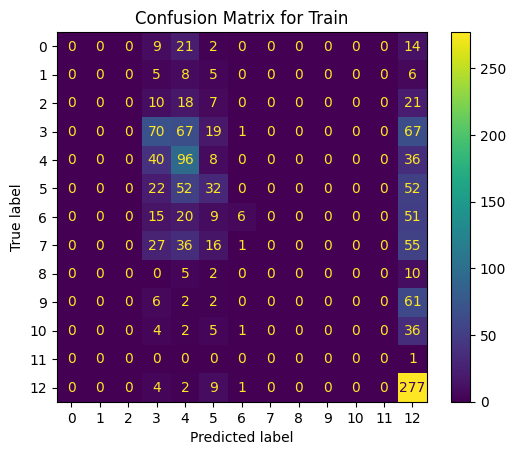

In [43]:
# Plot Confusion Matrix for Train
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Train")
plt.show()

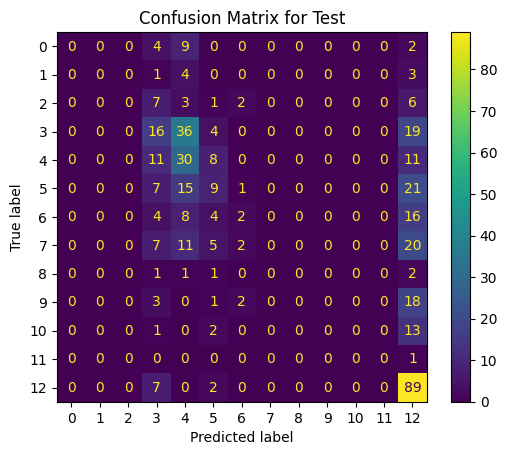

In [44]:
# Plot Confusion Matrix for Test
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Test")
plt.show()

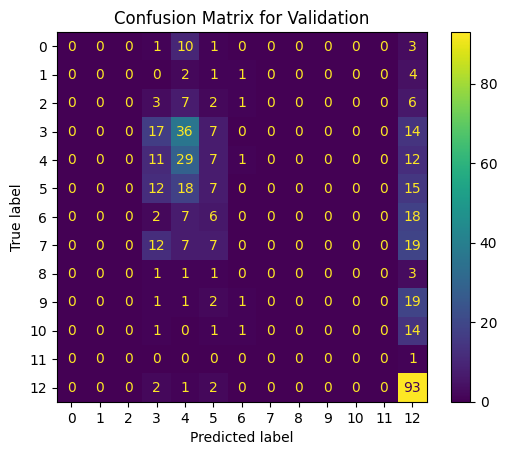

In [45]:
# Plot Confusion Matrix for Validation
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=final_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Validation")
plt.show()

In [ ]:
# Save both embeddings and classification model

model.save("./content/Tuned_all-MiniLM-L6-v2")

# To Open:
# model = SentenceTransformer("./content/Tuned_all-MiniLM-L6-v2")

with open("./content/xgboost_clf_model_with_transformer_tuning.pkl", "wb") as f:
    pickle.dump(final_model, f)

# To Open:
# with open("./content/xgboost_clf_model_with_transformer_tuning.pkl", "rb") as f:
#   model = pickle.load(f)